In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [3]:
ones_matrix = np.ones((5, 5))
ones_submatrix_view = ones_matrix[::2,::2] # creates a view, not copy
ones_matrix[::2,::2] = np.zeros((3, 3))
ones_submatrix_view

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [6]:
p = np.arange(1).reshape([1, 1, 1, 1])
p

array([[[[0]]]])

In [10]:
print("vstack: ", np.vstack((p, p)).shape)
print("hstack: ", np.hstack((p, p)).shape)
print("dstack: ", np.dstack((p, p)).shape)

vstack:  (2, 1, 1, 1)
hstack:  (1, 2, 1, 1)
dstack:  (1, 1, 2, 1)


In [11]:
np.concatenate((p, p), axis=3).shape

(1, 1, 1, 2)

In [12]:
base = ''
data = pd.read_csv(base + 'organisations.csv')
features = pd.read_csv(base + 'features.csv')
rubrics = pd.read_csv(base + 'rubrics.csv')

In [43]:
data.head()

,org_id,city,average_bill,rating,rubrics_id,features_id
0,15903868628669802651,msk,1500.0,4.270968,30776 30774,3501685156 3501779478 20422 3502045016 3502045...
1,16076540698036998306,msk,500.0,4.375000,30771,1509 1082283206 273469383 10462 11617 35017794...
2,8129364761615040323,msk,500.0,4.000000,31495,10462 11177 11617 11629 1416 1018 11704 11867 ...
3,15262729117594253452,msk,500.0,4.538813,30776 30770,3501618484 2020795524 11629 11617 1018 11704 2...
4,13418544315327784420,msk,500.0,4.409091,31495,11617 10462 11177 1416 11867 3501744275 20282 ...


In [16]:
features.head()

,feature_id,feature_name
0,1,prepress_and_post_printing_processing
1,40,products
2,54,printing_method
3,77,fuel
4,79,shop


In [14]:
feature_dict = dict(zip(features["feature_id"], features["feature_name"]))
rubric_dict = dict(zip(rubrics["rubric_id"], rubrics["rubric_name"]))
rubric_dict

{30519: 'Булочная, пекарня',
 30770: 'Бар, паб',
 30771: 'Быстрое питание',
 30774: 'Кафе',
 30775: 'Пиццерия',
 30776: 'Ресторан',
 30777: 'Столовая',
 31286: 'Спортбар',
 31350: 'Кондитерская',
 31375: 'Суши-бар',
 31401: 'Кальян-бар',
 31495: 'Кофейня',
 3108292683: 'Бар безалкогольных напитков',
 3501514558: 'Фудкорт',
 3501750896: 'Кофе с собой'}

In [213]:
ratio = data["average_bill"].isna().sum() / len(data["average_bill"])
data = data.dropna(subset=['average_bill'])
data = data.drop(data[data["average_bill"] > 2500].index)
data.shape

(32136, 6)

(array([22329.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  5482.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,  2696.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,  1184.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,   445.]),
 array([ 500.,  520.,  540.,  560.,  580.,  600.,  620.,  640.,  660.,
         680.,  700.,  

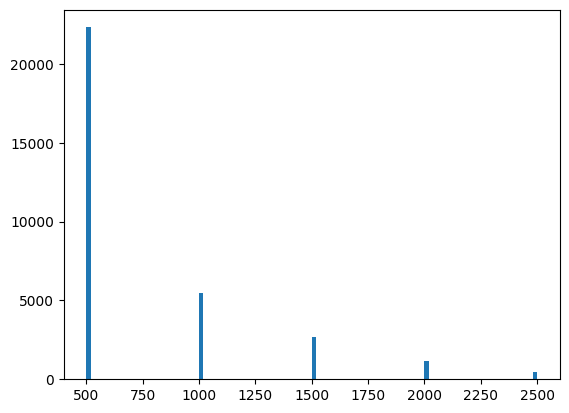

In [35]:
plt.hist(data["average_bill"], bins=100)

In [42]:
mean_vals_cities = data[["city", "average_bill"]].groupby(["city"]).mean()
mean_vals = round(mean_vals_cities.loc["msk"] - mean_vals_cities.loc["spb"])
mean_vals

average_bill    116.0
dtype: float64

In [55]:
def select_cafe(s):
    elems = s.split()
    for i in elems:
        if int(i) == 30774:
            return True
    return False

data_cafe = data[data["rubrics_id"].apply(select_cafe)]
mean_vals_cafe = data_cafe[["city", "average_bill"]].groupby(["city"]).mean()
mean_vals = round(mean_vals_cafe.loc["msk"] - mean_vals_cafe.loc["spb"])
mean_vals

average_bill    142.0
dtype: float64

In [214]:
clean_data_train, clean_data_test = train_test_split(
    data, stratify=data['average_bill'], test_size=0.33, random_state=42)

In [68]:
from scipy.stats import mode

from sklearn.base import RegressorMixin

class MeanRegressor(RegressorMixin):
    # Predicts the mean of y_train
    def fit(self, X=None, y=None):
        self.mean = np.mean(y)

    def predict(self, X=None):
        return np.full(shape=X.shape[0], fill_value=self.mean)

from sklearn.base import ClassifierMixin

class MostFrequentClassifier(ClassifierMixin):
    # Predicts the rounded (just in case) median of y_train
    def fit(self, X=None, y=None):
        self.most_frequent = round(np.median(y))

    def predict(self, X=None):
        return np.full(shape=X.shape[0], fill_value=self.most_frequent)

In [69]:
reg = MeanRegressor()
reg.fit(y=clean_data_train['average_bill'])

clf = MostFrequentClassifier()
clf.fit(y=clean_data_train['average_bill'])

In [75]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import balanced_accuracy_score

reg_mse_error = mean_squared_error(clean_data_test["average_bill"], reg.predict(clean_data_test), squared=False)

clf_mse_error = mean_squared_error(clean_data_test["average_bill"], clf.predict(clean_data_test), squared=False)

clf_bas_error = balanced_accuracy_score(clean_data_test["average_bill"], clf.predict(clean_data_test))

print(reg_mse_error, clf_mse_error, clf_bas_error)

448.7143889551622 514.7517402382093 0.2


In [76]:
class CityMeanRegressor(RegressorMixin):
    def fit(self, X=None, y=None):
        self.msk_mean = np.mean(y[X[X["city"] == "msk"].index])
        self.spb_mean = np.mean(y[X[X["city"] == "spb"].index])

    def predict(self, X=None):
        return self.msk_mean * (X["city"] == "msk") + self.spb_mean * (X["city"] == "spb")

In [78]:
city_reg = CityMeanRegressor()
city_reg.fit(X=clean_data_train, y=clean_data_train['average_bill'])

mean_squared_error(clean_data_test["average_bill"], city_reg.predict(clean_data_test), squared=False)

445.1063281403263

In [161]:
from collections import Counter

c_train = Counter(clean_data_train["rubrics_id"])
c_test = Counter(clean_data_test["rubrics_id"])

rubrics_to_replace_train = [key for key, value in c_train.items() if value < 100]
rubrics_to_replace_test = [key for key, value in c_test.items() if value < 100]

train_replaced_rubrics = clean_data_train.replace(rubrics_to_replace_train, "other")
test_replaced_rubrics = clean_data_test.replace(rubrics_to_replace_test, "other")

In [188]:
class CityRubricsMeanRegressor(RegressorMixin):
    def fit(self, X=None, y=None):
        average_bills_by_rubrics = X[["city", "rubrics_id", "average_bill"]].groupby(["city", "rubrics_id"]).mean()

    def predict(self, X=None):
        multi_ind = pd.MultiIndex.from_frame(X[["city", "rubrics_id"]])
        return average_bills_by_rubrics.loc[multi_ind]["average_bill"].to_numpy()

In [189]:
city_rubrics_reg = CityRubricsMeanRegressor()
city_rubrics_reg.fit(X=train_replaced_rubrics, y=train_replaced_rubrics["average_bill"])
mean_squared_error(test_replaced_rubrics["average_bill"], city_rubrics_reg.predict(test_replaced_rubrics), squared=False)

368.9342242289728

In [191]:
round(np.median(np.array([3, 7, 4])))

4

In [192]:
data.head()

,org_id,city,average_bill,rating,rubrics_id,features_id
0,15903868628669802651,msk,1500.0,4.270968,30776 30774,3501685156 3501779478 20422 3502045016 3502045...
1,16076540698036998306,msk,500.0,4.375000,30771,1509 1082283206 273469383 10462 11617 35017794...
2,8129364761615040323,msk,500.0,4.000000,31495,10462 11177 11617 11629 1416 1018 11704 11867 ...
3,15262729117594253452,msk,500.0,4.538813,30776 30770,3501618484 2020795524 11629 11617 1018 11704 2...
4,13418544315327784420,msk,500.0,4.409091,31495,11617 10462 11177 1416 11867 3501744275 20282 ...


In [216]:
clean_data_train["modified_features"] = clean_data_train["rubrics_id"] + " q " + clean_data_train["features_id"]

clean_data_test["modified_features"] = clean_data_test["rubrics_id"] + " q " + clean_data_test["features_id"]

clean_data_test.loc[~clean_data_test["modified_features"].isin(clean_data_train["modified_features"]), "modified_features"] = "other"

len(clean_data_test[clean_data_test["modified_features"] == "other"]) / clean_data_test.shape[0]

0.9548326261197548